In [2]:
%load_ext autoreload
%autoreload 2

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.spatial.distance import cdist
from sklearn.metrics import pairwise_distances
from shapely.geometry import Point, Polygon, box
import sys
sys.path.insert(0, 'C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Workshops\\Cedric\\josie_survey_visualisation')
from visualisation_funcs import *

In [157]:
from scipy.interpolate import RBFInterpolator
from scipy.stats import pearsonr

### Setup

In [15]:
# Resolution for the histogram (in meters)
kResolution = 200

# Flag and parameters for applying the log transformation (making the image more contrasted)
kApplyLog = True
kLogLengthscale = 1 # The bigger the more contrasted

# Flag to compute and show contours
kShowContour = True

# Smoothing parameters the bigger the smoother
kSmoothingFactor = 2

# Contour parameters
kContourFactor = 1.5 # The bigger the "larger" the contours
kContourMarkerSize = 0.5 # Marker size for visualization

# Output image resolution (under 100 starts to be quite slow)
kImgRes = 200

kQuestionValues = {20544:1, 20745:1, 20749:1, 20545:-1, 20746:-1, 20750:-1}

In [258]:
# Read the data
data = pd.read_csv('C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Workshops\\Cedric\\josie_survey_visualisation\\data\\cluster_data_15_6th.csv')

# sort data by id_person
data = data.sort_values(by=['id_person'])

# remove data where id_question is not in kQuestionValues
data = data[data['id_question'].isin(list(kQuestionValues.keys()))]

# add a 'question_value' column using kQuestionValues to convert questions to +/- 1
data['question_value'] = data['id_question'].map(kQuestionValues)

# import index
index = pd.read_csv('C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\HPM take 2\\Sydney_walk_241122.csv')
index_max = index['THERE_Index'].max()
index_min = index['THERE_Index'].min()

x_maxd = data['x'].max()
x_mind = data['x'].min()
y_maxd = data['y'].max()
y_mind = data['y'].min()
x_maxi = index['x'].max()
x_mini = index['x'].min()
y_maxi = index['y'].max()
y_mini = index['y'].min()

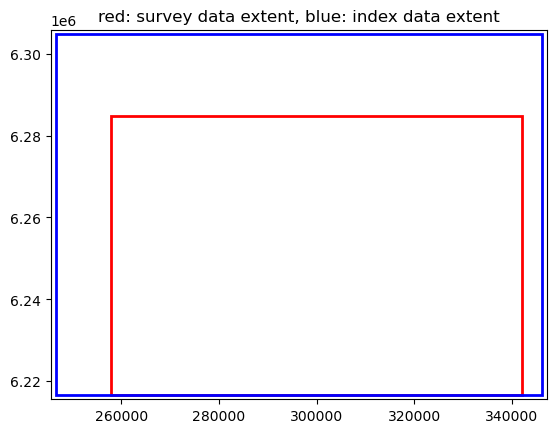

In [362]:
#plot two boxes, one defined by x_maxd, x_mind, y_maxd, y_mind, the other by x_maxi, x_mini, y_maxi, y_mini
fig, ax = plt.subplots(1)
#plot rectangle
rectd = Rectangle((x_mind, y_mind), x_maxd-x_mind, y_maxd-y_mind, fill=False, edgecolor='red', linewidth=2)
recti = Rectangle((x_mini, y_mini), x_maxi-x_mini, y_maxi-y_mini, fill=False, edgecolor='blue', linewidth=2)
ax.add_patch(rectd)
ax.add_patch(recti)
ax.set_xlim([min(x_mind, x_mini)-1000, max(x_maxd, x_maxi)+1000])
ax.set_ylim([min(y_mind, y_mini)-1000, max(y_maxd, y_maxi)+1000])
ax.set_title('red: survey data extent, blue: index data extent')
plt.show()

## Creation of additional points for circled responses

In [259]:
# import hulls?
import geopandas as gpd

hulls = gpd.read_file('C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Walkability\\Workshops\\Cedric\\josie_survey_visualisation\\data\\hulls_17_9th.gpkg')

In [260]:
relevant_hulls = hulls[hulls['question'].isin([1,2])]
relevant_hulls['question_value'] = relevant_hulls['question'].map({1:1, 2:-1})

c:\Users\z3258367\Anaconda3\envs\ox\lib\site-packages\geopandas\geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [261]:
def Random_Points_in_Bounds(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds
    area_ratio = polygon.area / ((maxx-minx) * (maxy-miny))
    x = np.random.uniform(minx, maxx, round(number/area_ratio))
    y = np.random.uniform(miny, maxy, round(number/area_ratio))
    df = pd.DataFrame()
    df['points'] = list(zip(x,y))
    df['geometry'] = df['points'].apply(Point)
    gdf_points = gpd.GeoDataFrame(df, geometry='geometry')
    return gdf_points

points = gpd.GeoDataFrame(columns=['geometry'], crs=hulls.crs)

# create random points covering each polygon
for i, hull in relevant_hulls.iterrows():
    if hull['concave']==0:
        hull_gdf = relevant_hulls[relevant_hulls.index==i]
        n = int(hull['density']*2 * hull['area'])
        gdf_points = Random_Points_in_Bounds(hull.geometry, n)
        gdf_points.set_crs(hulls.crs, inplace=True)
        gdf_points = gpd.sjoin(gdf_points, hull_gdf, predicate="within", how='left')
        pnts_in_poly = gdf_points[gdf_points.index_right==i]
        points = pd.concat([points, pnts_in_poly]).set_crs(hulls.crs)

points['x'] = points.geometry.x
points['y'] = points.geometry.y

In [262]:
data_with_points = data.copy()
data_with_points = data_with_points[~(data_with_points['concave']==0)]
data_with_points = pd.concat([data_with_points, points])

1.0637199139513667

## Image Creation

We set up image based on index data extent. We are only interested in image cells that have an index data value (for comparison purposes).

In [264]:
img_width = int((x_maxi - x_mini) / kResolution + 1)
img_height = int((y_maxi - y_mini) / kResolution + 1)

# Create the blank images
survey_data_counter = np.zeros((img_height, img_width))
index_counter_img = np.zeros((img_height, img_width))
buffer_index_counter = np.zeros((img_height, img_width))
survey_sum = np.zeros((img_height, img_width))
survey_var_img = np.zeros((img_height, img_width))
index_sum = np.zeros((img_height, img_width))
diff_img = np.zeros((img_height, img_width))
index_var_img = np.zeros((img_height, img_width))
survey_pos_sum = np.zeros((img_height, img_width))
survey_neg_sum = np.zeros((img_height, img_width))
survey_pos_counter = np.zeros((img_height, img_width))
survey_neg_counter = np.zeros((img_height, img_width))

In [265]:
df = data_with_points.copy()

In [266]:
survey_sum = np.zeros((img_height, img_width))
survey_data_counter = np.zeros((img_height, img_width))

# Fill the score image with the sum of user values
for i in range(len(df)):
    x = int((df['x'].iloc[i] - x_mini) / kResolution)
    y = int((df['y'].iloc[i] - y_maxi) / kResolution)
    survey_sum[y, x] += df['question_value'].iloc[i]
    survey_data_counter[y, x] += 1
    if df['question_value'].iloc[i] > 0:
        survey_pos_sum[y, x] += df['question_value'].iloc[i]
        survey_pos_counter[y, x] += 1
    elif df['question_value'].iloc[i] < 0:
        survey_neg_sum[y, x] += df['question_value'].iloc[i]
        survey_neg_counter[y, x] += 1

# Divide the score image by the counter image
survey_mean = survey_sum / survey_data_counter
survey_pos_mean = survey_pos_sum / survey_pos_counter
survey_neg_mean = survey_neg_sum / survey_neg_counter

# Fill the variance image
for i in range(len(df)):
    x = int((df['x'].iloc[i] - x_mini) / kResolution)
    y = int((df['y'].iloc[i] - y_maxi) / kResolution)
    survey_var_img[y,x] += (df['question_value'].iloc[i] - survey_mean[y,x]) ** 2

# Divide the variance image by the counter image
survey_var_img = survey_var_img / survey_data_counter

# Set NaN values to 0
survey_mean[np.isnan(survey_mean)] = 0
survey_var_img[np.isnan(survey_var_img)] = 0

# Data mask (were there is data)
survey_data_mask = survey_data_counter > 0

C:\Users\z3258367\AppData\Local\Temp\ipykernel_12784\3996207597.py:18: RuntimeWarning: invalid value encountered in divide
  survey_mean = survey_sum / survey_data_counter
C:\Users\z3258367\AppData\Local\Temp\ipykernel_12784\3996207597.py:19: RuntimeWarning: invalid value encountered in divide
  survey_pos_mean = survey_pos_sum / survey_pos_counter
C:\Users\z3258367\AppData\Local\Temp\ipykernel_12784\3996207597.py:20: RuntimeWarning: invalid value encountered in divide
  survey_neg_mean = survey_neg_sum / survey_neg_counter
C:\Users\z3258367\AppData\Local\Temp\ipykernel_12784\3996207597.py:29: RuntimeWarning: invalid value encountered in divide
  survey_var_img = survey_var_img / survey_data_counter


In [267]:
# in the end, most of this isn't used
# Fill the score image with the sum of user values
for i in range(len(index)):
    x = int((index['x'].iloc[i] - x_mini) / kResolution)
    y = int((index['y'].iloc[i] - y_mini) / kResolution)
    index_sum[y, x] += index['THERE_Index'].iloc[i]
    index_counter_img[y, x] += 1
    buffer_index_counter[y-2:y+2, x-2:x+2] += 1

# Divide the score image by the counter image
index_mean_img = index_sum / index_counter_img

# Fill the variance image
for i in range(len(index)):
    x = int((index['x'].iloc[i] - x_mini) / kResolution)
    y = int((index['y'].iloc[i] - y_mini) / kResolution)
    index_var_img[y,x] += (index['THERE_Index'].iloc[i] - index_mean_img[y,x]) ** 2

# Divide the variance image by the counter image
index_var_img = index_var_img / index_counter_img

# Set NaN values to 0
index_mean_img[np.isnan(index_mean_img)] = 0
index_var_img[np.isnan(index_var_img)] = 0

# Data mask (were there is data)
index_data_mask = index_counter_img > 0
buffer_index_mask = buffer_index_counter > 0

C:\Users\z3258367\AppData\Local\Temp\ipykernel_12784\96938449.py:10: RuntimeWarning: invalid value encountered in divide
  index_mean_img = index_sum / index_counter_img
C:\Users\z3258367\AppData\Local\Temp\ipykernel_12784\96938449.py:19: RuntimeWarning: invalid value encountered in divide
  index_var_img = index_var_img / index_counter_img


In [268]:
survey_mean_logs = np.log(np.abs(kLogLengthscale*survey_pos_sum) + 1) - np.log(np.abs(kLogLengthscale*survey_neg_sum) + 1)
survey_pos_log = np.log(np.abs(kLogLengthscale*survey_pos_sum) + 1)
survey_neg_log = np.log(np.abs(kLogLengthscale*survey_neg_sum) + 1)
mean_log_img_norm = (index_max - index_min) * (survey_mean_logs - survey_mean_logs.min()) / (survey_mean_logs.max() - survey_mean_logs.min())

## Interpolation

In [92]:
index = index[~index.duplicated(subset=['x'], keep='first')]

xgrid = np.mgrid[y_mini:y_maxi:complex(survey_sum.shape[0]), x_mini:x_maxi:complex(survey_sum.shape[1]), ]
xflat = xgrid.reshape(2, -1).T

yflat_index = RBFInterpolator(index[['y', 'x']].values, index.THERE_Index.values, neighbors=10, kernel='gaussian', epsilon=0.5)(xflat)
#28s with 100 neighbours, 6.5mins with 200 - with 1000m cell
# with 100m cell - 4.5mins with 100 neighbours
ygrid_index = yflat_index.reshape(xgrid.shape[1:3])

## Correlation

(array([[1.        , 0.36201294],
        [0.36201294, 1.        ]]),
 PearsonRResult(statistic=0.36201294466127226, pvalue=0.0))

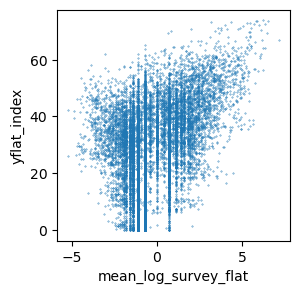

In [446]:
survey_data = survey_mean_logs
index_data = ygrid_index

survey_mask = survey_data_mask#[130:230,390:490]
flat_survey_mask = survey_mask.reshape(yflat_index.shape)

survey_data_flat = survey_data.reshape(yflat_index.shape,)[flat_survey_mask]
index_data_flat = index_data.reshape(yflat_index.shape)[flat_survey_mask]

fig, ax = plt.subplots(1,1, figsize=(3,3))
ax.scatter(survey_data_flat, index_data_flat, s=0.1)
ax.set_xlabel('mean_log_survey_flat')
ax.set_ylabel('yflat_index')
np.corrcoef(survey_data_flat, index_data_flat), pearsonr(survey_data_flat, index_data_flat)

## Visualisation

In [284]:
sydney_shape = gpd.read_file("C:\\Users\\z3258367\\OneDrive - UNSW\\#PhD\\Data\\Australia waterways shape\\sea near Sydney.gpkg")
sydney_water = sydney_shape.to_crs(hulls.crs)

In [431]:
min_x, max_x, min_y, max_y = 326000, 343184, 6259900, 6241400

x_min_cell = int((min_x - x_mini)/kResolution + 1)
x_max_cell = int((max_x - x_mini)/kResolution + 1)
y_min_cell = int((min_y - y_mini)/kResolution + 1)
y_max_cell = int((max_y - y_mini)/kResolution + 1)

bbox = [min_x, max_x, min_y, max_y]
bounding_box = box(bbox[0], bbox[2], bbox[1], bbox[3])
water_crop = sydney_water.intersection(bounding_box)

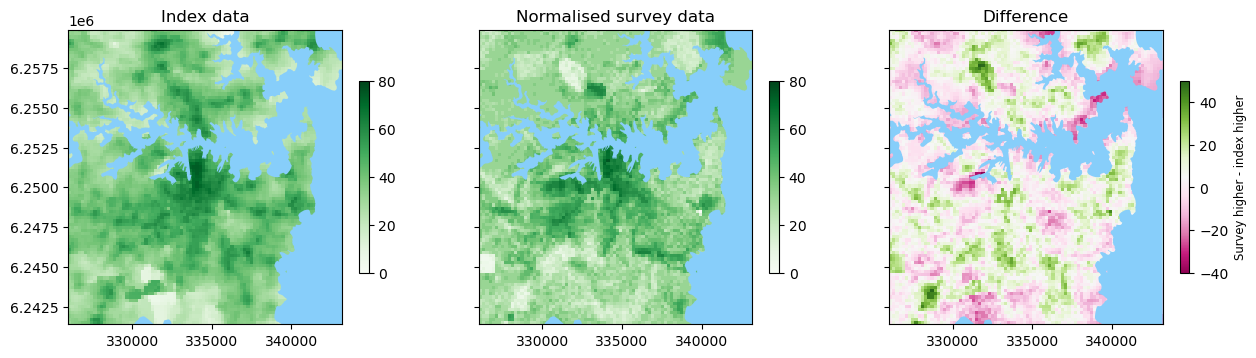

In [442]:
mean_log_img_norm = (index_max - index_min) * (survey_mean_logs - survey_mean_logs[y_max_cell:y_min_cell, x_min_cell:x_max_cell].min()) / (survey_mean_logs[y_max_cell:y_min_cell, x_min_cell:x_max_cell].max() - survey_mean_logs[y_max_cell:y_min_cell, x_min_cell:x_max_cell].min())

diff_log = ygrid_index - mean_log_img_norm

images = [ygrid_index, mean_log_img_norm, diff_log]
names = ['Index data', 'Normalised survey data', 'Difference']
vmins = [0, 0, None]
vmaxs = [80, 80, None]
palette = plt.cm.PiYG.with_extremes(over='r', under='g', bad='lightgrey')
cmaps = ['Greens', 'Greens', palette]
labels = [None, None, 'Survey higher - index higher']
cbs = [True, True, True]

fig, axs = plt.subplots(1,3, figsize=(15,5), sharey=True)

for image, name, ax, vi, va, cmap, label, cbtrue in zip(images, names, axs.ravel(), vmins, vmaxs, cmaps, labels, cbs):
    ygridm = image #np.ma.masked_where((index_data_mask)==0, image)
    im = ax.imshow(ygridm[y_max_cell:y_min_cell, x_min_cell:x_max_cell], origin='lower', extent=[min_x, max_x, max_y, min_y], vmin=vi, vmax=va, cmap=cmap)
    water_crop.plot(ax=ax, color='lightskyblue')
    if cbtrue:
        cb = fig.colorbar(im, ax=ax, shrink=0.5)
        cb.set_label(label, fontsize='small')
    ax.set_title(name)

plt.savefig("comparison_22_9.jpg", dpi=2400)